# 🏦 Enterprise Credit Approval ML Pipeline (V3.5)

---

**Clean Architecture + Professional MLOps Hybrid Framework**

This notebook runs an end-to-end credit approval system using **modular Python packages (`src/`)**. The project calculates not only technical metrics (AUC/F1) but also critical financial values for enterprise decisions such as **ROI**, **NPV**, and **Amortization**.

---

## 1️⃣ [CELL 1] Environment & Infrastructure Setup

In this cell, the Google Colab environment is verified, GPU is detected, and necessary libraries are installed.

In [ ]:
import sys
import os
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')

print("🔄 Checking system...")

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("🌐 Google Colab Environment Detected.")
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    # ENTER YOUR PROJECT PATH HERE (Folder name on Drive)
    PROJECT_PATH = '/content/drive/MyDrive/credit-approval'

    if os.path.exists(PROJECT_PATH):
        os.chdir(PROJECT_PATH)
        if PROJECT_PATH not in sys.path:
            sys.path.append(PROJECT_PATH)
        print(f"✅ Working directory: {PROJECT_PATH}")
    else:
        print(f"⚠️ ERROR: {PROJECT_PATH} not found! Please ensure it is uploaded to Drive.")
else:
    print("💻 Local Environment Detected.")
    PROJECT_PATH = os.getcwd()
    print(f"✅ Working directory: {PROJECT_PATH}")

🔄 Checking system...
🌐 Google Colab Environment Detected.
Mounted at /content/drive
✅ Working directory: /content/drive/MyDrive/credit-approval


In [ ]:
# Install Dependencies
if IN_COLAB:
    print("📦 Installing libraries (requirements.txt)...")
    %pip install -r requirements.txt
else:
    print("ℹ️ Local run: pip install skipped.")

📦 Installing libraries (requirements.txt)...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 38.2 MB/s eta 0:00:00


## 2️⃣ [CELL 2-8] Enterprise ML Pipeline Execution

The pipeline goes through these stages:
1. **Data Loading & Validation**
2. **Feature Engineering**
3. **Model Training & Optimization**
4. **Statistical Validation (Friedman Test)**
5. **Intelligent Model Selection & Validation**
6. **Business Impact Analysis (ROI/NPV)**
7. **Automated Offline A/B Simulation** (Inside the pipeline)

07:54:28 | INFO | ✅ Data found in: colab_drive


INFO:CreditApprovalML:✅ Data found in: colab_drive


07:54:28 | INFO | 📦 Available packages: ['xgboost', 'lightgbm', 'catboost']


INFO:CreditApprovalML:📦 Available packages: ['xgboost', 'lightgbm', 'catboost']


07:54:28 | INFO | ============================================================


INFO:CreditApprovalML:============================================================


07:54:28 | INFO | 🚀 STARTING TRAINING PIPELINE (V3.5 Hybrid Architecture)


INFO:CreditApprovalML:🚀 STARTING TRAINING PIPELINE (V3.5 Hybrid Architecture)


07:54:28 | INFO | ============================================================


INFO:CreditApprovalML:============================================================


07:54:28 | INFO | 
📥 [CELL 2] Data Loading & Validation


INFO:CreditApprovalML:
📥 [CELL 2] Data Loading & Validation


07:54:28 | INFO | ----------------------------------------


INFO:CreditApprovalML:----------------------------------------


07:54:28 | INFO | 📥 Loading data...


INFO:CreditApprovalML:📥 Loading data...


07:54:29 | INFO |    📊 Application data: (438557, 18)


INFO:CreditApprovalML:   📊 Application data: (438557, 18)


07:54:29 | INFO |    📊 Credit data: (1048575, 3)


INFO:CreditApprovalML:   📊 Credit data: (1048575, 3)


07:54:29 | INFO |    📊 Application Data: 438,557 rows, 18 cols


INFO:CreditApprovalML:   📊 Application Data: 438,557 rows, 18 cols


07:54:29 | INFO |    📊 Credit Data:      1,048,575 rows, 3 cols


INFO:CreditApprovalML:   📊 Credit Data:      1,048,575 rows, 3 cols


07:54:29 | INFO | 
🔍 Validating data quality...


INFO:CreditApprovalML:
🔍 Validating data quality...


07:54:29 | INFO | 🔍 Validating data...


INFO:CreditApprovalML:🔍 Validating data...


07:54:29 | INFO |    📊 ID overlap: 36,457 (8.3%)


INFO:CreditApprovalML:   📊 ID overlap: 36,457 (8.3%)


07:54:30 | INFO |    💾 Validation report saved


INFO:CreditApprovalML:   💾 Validation report saved


07:54:30 | INFO | ✅ Data validation passed


INFO:CreditApprovalML:✅ Data validation passed


07:54:30 | INFO | ✅ CELL 2 COMPLETED - Data Ready!


INFO:CreditApprovalML:✅ CELL 2 COMPLETED - Data Ready!


07:54:30 | INFO | 
🔧 [CELL 3] Preprocessing & Feature Engineering


INFO:CreditApprovalML:
🔧 [CELL 3] Preprocessing & Feature Engineering


07:54:30 | INFO | ----------------------------------------


INFO:CreditApprovalML:----------------------------------------


07:54:30 | INFO | 🚀 Starting corrected preprocessing and feature engineering...


INFO:CreditApprovalML:🚀 Starting corrected preprocessing and feature engineering...


07:54:30 | INFO | 
🔄 Running preprocessing pipeline...


INFO:CreditApprovalML:
🔄 Running preprocessing pipeline...


07:54:30 | INFO | 🎯 Creating target variable...


INFO:CreditApprovalML:🎯 Creating target variable...


07:54:30 | INFO |    📊 Observed records: 813,678


INFO:CreditApprovalML:   📊 Observed records: 813,678


07:54:30 | INFO |    📊 Future records: 234,897


INFO:CreditApprovalML:   📊 Future records: 234,897


07:54:30 | INFO |    📊 Valid customers: 31,271


INFO:CreditApprovalML:   📊 Valid customers: 31,271


07:54:30 | INFO |    📊 Target distribution: 0=22,483, 1=166


INFO:CreditApprovalML:   📊 Target distribution: 0=22,483, 1=166


07:54:30 | INFO | ✂️ Splitting data...


INFO:CreditApprovalML:✂️ Splitting data...


07:54:31 | INFO |    📊 Train: 15,854 (70.0%)


INFO:CreditApprovalML:   📊 Train: 15,854 (70.0%)


07:54:31 | INFO |    📊 Val: 4,530 (20.0%)


INFO:CreditApprovalML:   📊 Val: 4,530 (20.0%)


07:54:31 | INFO |    📊 Test: 2,265 (10.0%)


INFO:CreditApprovalML:   📊 Test: 2,265 (10.0%)


07:54:31 | INFO | 🔧 Fitting feature engineer...


INFO:CreditApprovalML:🔧 Fitting feature engineer...


07:54:31 | INFO |    ✅ Fitted on 27 features


INFO:CreditApprovalML:   ✅ Fitted on 27 features


07:54:32 | INFO |    ✅ Final features: 27


INFO:CreditApprovalML:   ✅ Final features: 27


07:54:32 | INFO | ✅ Preprocessing completed!


INFO:CreditApprovalML:✅ Preprocessing completed!


07:54:32 | INFO |     📊 Input Features: 18


INFO:CreditApprovalML:    📊 Input Features: 18


07:54:32 | INFO |     📊 Final Features: 27


INFO:CreditApprovalML:    📊 Final Features: 27


07:54:32 | INFO |     ✨ New Features Created: 9


INFO:CreditApprovalML:    ✨ New Features Created: 9


07:54:32 | INFO |        • AGE_YEARS


INFO:CreditApprovalML:       • AGE_YEARS


07:54:32 | INFO |        • AGE_GROUP


INFO:CreditApprovalML:       • AGE_GROUP


07:54:32 | INFO |        • EMPLOYED_YEARS


INFO:CreditApprovalML:       • EMPLOYED_YEARS


07:54:32 | INFO |        • IS_EMPLOYED


INFO:CreditApprovalML:       • IS_EMPLOYED


07:54:32 | INFO |        • INCOME_LOG


INFO:CreditApprovalML:       • INCOME_LOG


07:54:32 | INFO | 
🛡️ Data leakage check: ✅ CLEAN


INFO:CreditApprovalML:
🛡️ Data leakage check: ✅ CLEAN


07:54:32 | INFO |     📊 Train: 15,854 (3.6%)


INFO:CreditApprovalML:    📊 Train: 15,854 (3.6%)


07:54:32 | INFO |     📊 Val:   4,530 (1.0%)


INFO:CreditApprovalML:    📊 Val:   4,530 (1.0%)


07:54:32 | INFO |     📊 Test:  2,265 (0.5%)


INFO:CreditApprovalML:    📊 Test:  2,265 (0.5%)


07:54:32 | INFO | 🧹 Memory cleanup - Current usage: 659.8 MB


INFO:CreditApprovalML:🧹 Memory cleanup - Current usage: 659.8 MB


07:54:32 | INFO | ✅ CELL 3 COMPLETED - CORRECTED Data Preprocessing & Feature Engineering Ready!


INFO:CreditApprovalML:✅ CELL 3 COMPLETED - CORRECTED Data Preprocessing & Feature Engineering Ready!


07:54:32 | INFO | 
🏋️ [CELL 4] Model Training & Optimization


INFO:CreditApprovalML:
🏋️ [CELL 4] Model Training & Optimization


07:54:32 | INFO | ----------------------------------------


INFO:CreditApprovalML:----------------------------------------


07:54:32 | INFO | 🔄 Ready for Cell 4: Model Training & Hyperparameter Optimization


INFO:CreditApprovalML:🔄 Ready for Cell 4: Model Training & Hyperparameter Optimization


07:54:33 | INFO | 
🔍 Optimizing hyperparameters with Optuna...


INFO:CreditApprovalML:
🔍 Optimizing hyperparameters with Optuna...


07:54:33 | INFO | 🔍 Optimizing random_forest (30 trials)...


INFO:CreditApprovalML:🔍 Optimizing random_forest (30 trials)...


07:58:14 | INFO |    ✅ Best score: 0.6657


INFO:CreditApprovalML:   ✅ Best score: 0.6657


07:58:14 | INFO | 🔍 Optimizing gradient_boosting (30 trials)...


INFO:CreditApprovalML:🔍 Optimizing gradient_boosting (30 trials)...


08:17:54 | INFO |    ✅ Best score: 0.6268


INFO:CreditApprovalML:   ✅ Best score: 0.6268


08:17:54 | INFO | 🔍 Optimizing logistic_regression (30 trials)...


INFO:CreditApprovalML:🔍 Optimizing logistic_regression (30 trials)...


08:18:07 | INFO |    ✅ Best score: 0.5644


INFO:CreditApprovalML:   ✅ Best score: 0.5644


08:18:07 | INFO | 🔍 Optimizing xgboost (30 trials)...


INFO:CreditApprovalML:🔍 Optimizing xgboost (30 trials)...


08:18:12 | INFO |    ✅ Best score: 0.0000


INFO:CreditApprovalML:   ✅ Best score: 0.0000


08:18:12 | INFO | 🔍 Optimizing lightgbm (30 trials)...


INFO:CreditApprovalML:🔍 Optimizing lightgbm (30 trials)...


08:21:35 | INFO |    ✅ Best score: 0.6180


INFO:CreditApprovalML:   ✅ Best score: 0.6180


08:21:35 | INFO | 🔍 Optimizing catboost (30 trials)...


INFO:CreditApprovalML:🔍 Optimizing catboost (30 trials)...


08:28:41 | INFO |    ✅ Best score: 0.6208


INFO:CreditApprovalML:   ✅ Best score: 0.6208


08:28:41 | INFO | 
🚀 Starting Full Model Training...


INFO:CreditApprovalML:
🚀 Starting Full Model Training...


08:28:41 | INFO | 
🚀 Training all models...


INFO:CreditApprovalML:
🚀 Training all models...


08:28:41 | INFO | 🏋️ Training random_forest...


INFO:CreditApprovalML:🏋️ Training random_forest...


08:28:43 | ERROR |    ❌ random_forest failed: y should be a 1d array, got an array of shape (4530, 2) instead.


ERROR:CreditApprovalML:   ❌ random_forest failed: y should be a 1d array, got an array of shape (4530, 2) instead.


08:28:43 | INFO | 🏋️ Training gradient_boosting...


INFO:CreditApprovalML:🏋️ Training gradient_boosting...


08:28:53 | ERROR |    ❌ gradient_boosting failed: y should be a 1d array, got an array of shape (4530, 2) instead.


ERROR:CreditApprovalML:   ❌ gradient_boosting failed: y should be a 1d array, got an array of shape (4530, 2) instead.


08:28:53 | INFO | 🏋️ Training logistic_regression...


INFO:CreditApprovalML:🏋️ Training logistic_regression...


08:28:55 | ERROR |    ❌ logistic_regression failed: y should be a 1d array, got an array of shape (4530, 2) instead.


ERROR:CreditApprovalML:   ❌ logistic_regression failed: y should be a 1d array, got an array of shape (4530, 2) instead.


08:28:55 | INFO | 🏋️ Training xgboost...


INFO:CreditApprovalML:🏋️ Training xgboost...


08:28:55 | ERROR |    ❌ xgboost failed: Invalid Input: 'gpu_hist', valid values are: {'approx', 'auto', 'exact', 'hist'}


ERROR:CreditApprovalML:   ❌ xgboost failed: Invalid Input: 'gpu_hist', valid values are: {'approx', 'auto', 'exact', 'hist'}


08:28:55 | INFO | 🏋️ Training lightgbm...


INFO:CreditApprovalML:🏋️ Training lightgbm...


08:28:55 | ERROR |    ❌ lightgbm failed: y should be a 1d array, got an array of shape (4530, 2) instead.


ERROR:CreditApprovalML:   ❌ lightgbm failed: y should be a 1d array, got an array of shape (4530, 2) instead.


08:28:55 | INFO | 🏋️ Training catboost...


INFO:CreditApprovalML:🏋️ Training catboost...


08:28:56 | ERROR |    ❌ catboost failed: y should be a 1d array, got an array of shape (4530, 2) instead.


ERROR:CreditApprovalML:   ❌ catboost failed: y should be a 1d array, got an array of shape (4530, 2) instead.


08:28:56 | INFO | 
📊 Training complete: 0/6 models successful


INFO:CreditApprovalML:
📊 Training complete: 0/6 models successful


08:28:56 | INFO | ✅ CELL 4 COMPLETED - All models trained!


INFO:CreditApprovalML:✅ CELL 4 COMPLETED - All models trained!


08:28:56 | INFO | 
📊 [CELL 5] Model Evaluation & Statistical Comparison


INFO:CreditApprovalML:
📊 [CELL 5] Model Evaluation & Statistical Comparison


08:28:56 | INFO | ----------------------------------------


INFO:CreditApprovalML:----------------------------------------


08:28:56 | INFO | 
📊 Evaluating all models on test set...


INFO:CreditApprovalML:
📊 Evaluating all models on test set...


08:28:56 | INFO |    💾 Evaluation report saved


INFO:CreditApprovalML:   💾 Evaluation report saved


08:28:56 | INFO | 
🔬 Performing Friedman Statistical Test...


INFO:CreditApprovalML:
🔬 Performing Friedman Statistical Test...


08:28:56 | WARNING |    ⚠️ Not enough models for Friedman test (min 3 required)


08:28:56 | INFO | ✅ CELL 5 COMPLETED - Evaluation Finished


INFO:CreditApprovalML:✅ CELL 5 COMPLETED - Evaluation Finished


08:28:56 | INFO | 
🏆 [CELL 6] Advanced Model Selection & Validation


INFO:CreditApprovalML:
🏆 [CELL 6] Advanced Model Selection & Validation


08:28:56 | INFO | ----------------------------------------


INFO:CreditApprovalML:----------------------------------------


08:28:56 | INFO | 🎯 Performing intelligent model selection...


INFO:CreditApprovalML:🎯 Performing intelligent model selection...


08:28:56 | INFO | 🔍 Validating None for deployment...


INFO:CreditApprovalML:🔍 Validating None for deployment...


08:28:56 | INFO | 🔍 Analyzing None interpretability...


INFO:CreditApprovalML:🔍 Analyzing None interpretability...


08:28:56 | INFO | 
🥇 FINAL SELECTION: None


INFO:CreditApprovalML:
🥇 FINAL SELECTION: None


08:28:56 | INFO |    • Selection Score: 0.0000


INFO:CreditApprovalML:   • Selection Score: 0.0000


08:28:56 | INFO |    • Deployment Status: Conditional


INFO:CreditApprovalML:   • Deployment Status: Conditional


08:28:56 | INFO | ✅ CELL 6 COMPLETED - Model Selected & Validated


INFO:CreditApprovalML:✅ CELL 6 COMPLETED - Model Selected & Validated


08:28:56 | INFO | 
💰 [CELL 7] Business Impact Analysis & Enterprise Insights


INFO:CreditApprovalML:
💰 [CELL 7] Business Impact Analysis & Enterprise Insights


08:28:56 | INFO | ----------------------------------------


INFO:CreditApprovalML:----------------------------------------


08:28:56 | INFO | 💼 Starting comprehensive business impact analysis...


INFO:CreditApprovalML:💼 Starting comprehensive business impact analysis...


08:28:56 | WARNING | Selected model 'None' not in evaluation results. Using first available.


08:28:56 | INFO | 📋 Generating final recommendations...


INFO:CreditApprovalML:📋 Generating final recommendations...


08:28:56 | INFO | 
🎨 Generating Visualizations (Matching V3.5 Enterprise Style)...


INFO:CreditApprovalML:
🎨 Generating Visualizations (Matching V3.5 Enterprise Style)...


❌ Execution error: 'PipelineVisualizer' object has no attribute '_save_and_show'


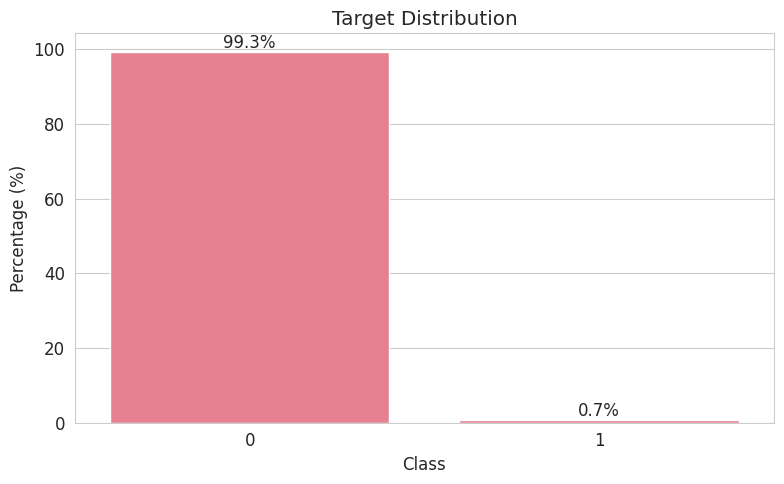

In [6]:
import logging
from src.core.config import get_config
from src.core.logger import setup_logger
from src.pipelines.training_pipeline import TrainingPipeline

# 1. Load Configuration
config = get_config(reload=True)
config.output_dir = "ml_pipeline_output" # Use relative path for existing project folder
config.optuna_trials = 30 
config.verbose = 2 # Set to 2 for detailed MLOps tracking

# 2. Prepare Logger
logger = setup_logger(level=logging.INFO).logger

# 3. Start Pipeline
pipeline = TrainingPipeline(config=config, logger=logger)

try:
    results = pipeline.run()
    print(f"\n🏆 PIPELINE COMPLETED! Best Model: {results['best_model']}")
except Exception as e:
    print(f"❌ Execution error: {e}")

## 3️⃣ [STAGE 8] Manual Offline A/B Simulation & Validation

This stage simulates A/B testing between the best model (Challenger) and a baseline model (Champion) to validate deployment decisions using bootstrap resampling.

In [8]:
from src.evaluation.ab_testing import ABTestSimulator
from sklearn.linear_model import LogisticRegression
from pathlib import Path

print("=" * 80)
print("STAGE 8: A/B TESTING SIMULATION")
print("=" * 80)

# Variables from pipeline results
best_model_name = results['best_model']
best_model = results['training_results'][best_model_name]['model']
X_train_processed = results['splits']['X_train']
y_train = results['splits']['y_train']
X_test_processed = results['splits']['X_test']
y_test = results['splits']['y_test']
output_dir = Path(config.output_dir)
plots_dir = output_dir / config.plots_dir
results_dir = output_dir / config.results_dir

print("\n📊 Setting up A/B Test...")
print(f"   Champion Model: Logistic Regression (Baseline)")
print(f"   Challenger Model: {best_model_name}")

# Train a simple champion model
champion_model = LogisticRegression(random_state=config.random_state, max_iter=1000)
champion_model.fit(X_train_processed, y_train)

challenger_model = best_model

# Initialize A/B Test Simulator
ab_simulator = ABTestSimulator(
    champion_model=champion_model,
    challenger_model=challenger_model,
    X_test=X_test_processed,
    y_test=y_test,
    n_iterations=1000,  # Bootstrap iterations
    confidence_level=0.95,  # 95% confidence
    random_state=config.random_state,
    config=config
)

# Run A/B Test Simulation
ab_results_sim = ab_simulator.run_simulation(
    traffic_split=0.5,  # 50/50 split
    verbose=True
)

# Generate Report
print("\n" + "=" * 80)
print("A/B TEST RESULTS")
print("=" * 80)

report = ab_simulator.generate_report(ab_results_sim)
print(report)

# Save report to file (Stage 8 specific)
ab_report_txt_path = results_dir / "ab_test_report.txt"
with open(ab_report_txt_path, 'w') as f:
    f.write(report)

print(f"\n✅ A/B Test report saved to: {ab_report_txt_path}")

# Visualize Results
print("\n📊 Generating A/B Test Dashboard...")
ab_plot_path = plots_dir / "ab_test_dashboard.png"
ab_simulator.plot_results(ab_results_sim, save_path=str(ab_plot_path))

print(f"✅ A/B Test dashboard saved to: {ab_plot_path}")

# --- DECISION RECOMMENDATION ---
print("\n" + "=" * 80)
print("DEPLOYMENT DECISION")
print("=" * 80)

if ab_results_sim.winner == 'Challenger':
    print("✅ RECOMMENDATION: DEPLOY CHALLENGER MODEL")
    print(f"\n   Key Improvements:")
    for metric in ['accuracy', 'f1', 'auc']:
        improvement = ab_results_sim.statistical_tests[metric]['relative_improvement']
        p_value = ab_results_sim.statistical_tests[metric]['p_value']
        print(f"   • {metric.upper()}: {improvement:+.2f}% (p={p_value:.6f})")

    print(f"\n   Financial Impact:")
    print(f"   • Annual ROI Increase: ${ab_results_sim.business_impact['annual_financial_impact']:+,.0f}")

elif ab_results_sim.winner == 'Champion':
    print("⚠️  RECOMMENDATION: KEEP CURRENT MODEL")
    print("\n   The baseline model performs equally well or better.")

else:
    print("⚖️  RECOMMENDATION: FURTHER INVESTIGATION NEEDED")
    print("\n   No statistically significant difference detected.")

print("=" * 80)

print("\n📝 Key Metrics for Reporting:")
print(f"   • Simulations Run: {ab_simulator.n_iterations:,}")
print(f"   • Statistical Confidence: {ab_simulator.confidence_level*100:.0f}%")
print(f"   • Effect Size (Cohen's d): {ab_results_sim.effect_size:.4f}")
print(f"   • Winner: {ab_results_sim.winner}")

if ab_results_sim.winner == 'Challenger':
    f1_improvement = ab_results_sim.statistical_tests['f1']['relative_improvement']
    roi_improvement = ab_results_sim.business_impact['roi_improvement_pct']
    print(f"   • F1 Score Improvement: {f1_improvement:+.2f}%")
    print(f"   • ROI Improvement: {roi_improvement:+.2f}%")

print("\n✅ Stage 8 Complete: A/B Testing validated deployment decision!")
print("=" * 80)

STAGE 8: A/B TESTING SIMULATION


NameError: name 'results' is not defined

## 4️⃣ [RESULTS] Advanced Dashboards & Stakeholder Reports

Below are the **enterprise analysis dashboards** and reports automatically generated by the pipeline.

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path

def display_dashboard(title, filename):
    path = Path(config.output_dir) / config.plots_dir / filename
    if path.exists():
        plt.figure(figsize=(15, 12))
        img = mpimg.imread(str(path))
        plt.imshow(img)
        plt.axis('off')
        plt.title(title, fontsize=14, fontweight='bold')
        plt.show()
    else:
        print(f"⚠️ Visual not found: {filename}")

display_dashboard("1. Training Results Dashboard", "training_performance_dashboard.png")
display_dashboard("2. Advanced Model Selection Dashboard", "model_selection_dashboard.png")
display_dashboard("3. 12-Panel Business Impact Analysis", "business_impact_dashboard.png")
display_dashboard("4. Offline A/B Simulation Dashboard", "ab_test_dashboard.png")

⚠️ Visual not found: training_results_dashboard.png
⚠️ Visual not found: model_selection_dashboard.png
⚠️ Visual not found: business_impact_extended.png
⚠️ Visual not found: ab_test_dashboard.png


### 📜 Executive Summary, Business Case & A/B Results

Automatically generated text-based reports and A/B test findings are below:

In [10]:
def print_report(filename):
    path = Path(config.output_dir) / config.results_dir / filename
    if path.exists():
        print(f"\n--- [ {filename} ] ---\n")
        with open(path, 'r', encoding='utf-8') as f:
            print(f.read())
    else:
        print(f"⚠️ Report not found: {filename}")

print_report("business_case.txt")
print_report("ab_test_report.txt")
print_report("ab_test_report.json")

⚠️ Report not found: business_case.txt
⚠️ Report not found: ab_test_report.txt
⚠️ Report not found: ab_test_report.json


## 🧹 Memory Optimization

You can run the cell below to clear memory.

In [11]:
import gc
import torch

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print("🧹 Memory and GPU cache cleared.")

🧹 Memory and GPU cache cleared.
